In [1]:
import cPickle as pkl
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pandas as pd

'''
import random
from statsmodels.nonparametric.smoothers_lowess import lowess
'''

'\nimport random\nfrom statsmodels.nonparametric.smoothers_lowess import lowess\n'

In [2]:
filepath = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"

In [3]:
results = pkl.load(open(filepath))

In [4]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

In [5]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 167.580508475
YAL038W 141.609887006
YJL189W 133.568361582
YCR012W 129.352259887
YOL086C 135.939548023
YLR110C 124.482047516
YLR044C 223.223163842
YKL152C 132.904884319


In [6]:
transcriptome_shah = pkl.load(open('../parameters/transcriptome_shah.p'))

In [7]:
prot_per_transcript_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_per_transcript_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / \
        transcriptome_shah[prot] / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_per_transcript_speeds[prot] > 0.25: 
        print prot, prot_per_transcript_speeds[prot]

YJL158C 0.251702025481
YDR461W 0.267514124294
YDR224C 0.258764371875
YLR388W 0.266384180791


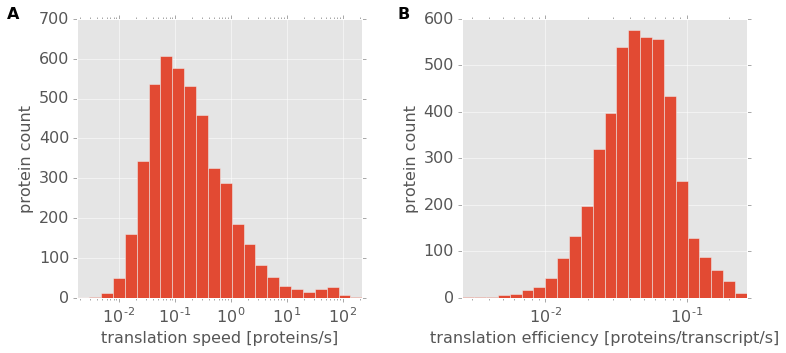

In [8]:
plt.rcParams['figure.figsize'] = (12, 5)

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121)
n, bins, patches = ax.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 25))
ax.set_xscale("log")
ax.set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
ax.set_xlabel('translation speed [proteins/s]', fontsize=16)
ax.set_ylabel('protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0001, 700, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(122)
n, bins, patches = ax.hist(prot_per_transcript_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                              np.log10(max(prot_per_transcript_speeds.values())), 32))
ax.set_xscale("log")
ax.set_xlim([min(prot_per_transcript_speeds.values())+0.002, max(prot_per_transcript_speeds.values())])
ax.set_xlabel('translation efficiency [proteins/transcript/s]', fontsize=16)
ax.set_ylabel('protein count', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.text(0.0009, 600, "B", fontsize=16, weight="bold")

plt.show()

In [9]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [10]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

/home/martin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [11]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [12]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [13]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [14]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [15]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic toc [s]']

In [16]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [17]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [18]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

In [19]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

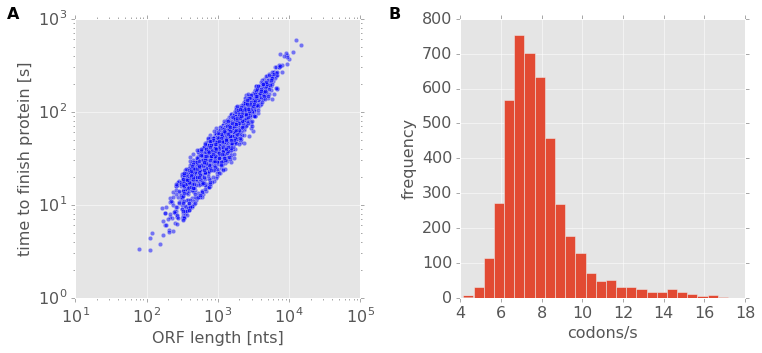

In [20]:
plt.rcParams['figure.figsize'] = (12, 5)

fig = plt.figure()
fig.subplots_adjust(wspace=0.35)

ax = fig.add_subplot(121)
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.5)
ax.set_xlabel('ORF length [nts]', fontsize=16)
ax.set_ylabel('time to finish protein [s]', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')

plt.text(1.1, 1000, "A", fontsize=16, weight="bold")

ax = fig.add_subplot(122)
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5))
ax.set_xlabel('codons/s', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

plt.text(0.5, 800, "B", fontsize=16, weight="bold")

plt.show()

## Ribosome ramp

In [30]:
import shelve

filepath = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2052.db"
d = shelve.open(filepath)

In [31]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last polysome to catch steady state

    # Select only every third element (the others are zero anyway):
    # translate the model's polysome format to lattice of ones and zeros:
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

This is now a dictionary that contains for every gene an array of the total ribosomes bound at the corresponding codon positions.

In [33]:
avg_ribos_per_gene = {}

for gene in ribo_lattice_dict:
    avg_ribos_per_gene[gene] = np.mean(ribo_lattice_dict[gene])

In [34]:
z = {}

for gene in ribo_lattice_dict:
    if avg_ribos_per_gene[gene]>0:
        z[gene] = ribo_lattice_dict[gene] / avg_ribos_per_gene[gene]

In [35]:
ramp_genes = set(z.keys()) & set(orf_lengths.keys())
len(ramp_genes)

4338

In [36]:
max_gene_length = max(orf_lengths.values())/3.0
max_gene_length

4911.0

In [37]:
import math

e = []
for j in range(int(max_gene_length)):
    numer = 0.0
    for gene in ramp_genes:
        if orf_lengths[gene]/3 > j:
            if not math.isnan(z[gene][j]):
                numer += z[gene][j]
    denom = sum([1 if orf_lengths[gene] >= j else 0 for gene in ramp_genes]) * 1.0
    e.append(numer/denom)

In [38]:
eprime = np.array(e) / (sum(e[449:500]) / 51.0)

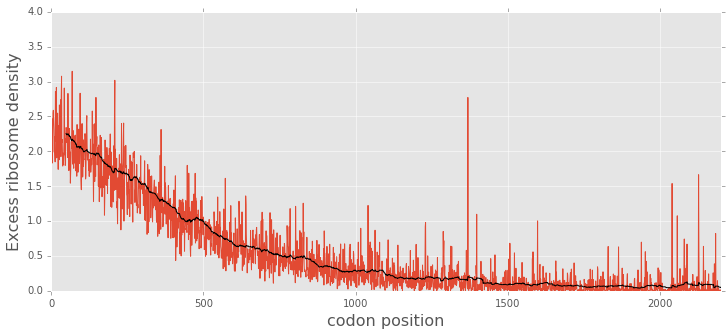

In [44]:
plt.plot(eprime)
plt.xlabel('codon position', fontsize=16)
plt.ylabel('Excess ribosome density', fontsize=16)
pd.rolling_mean(pd.Series(eprime), 50).plot(style='k')
plt.xlim([0, 2200]);
plt.ylim([0, 4]);